In [3]:
#-----get the train set of the face images-----
import cv2

#use the camera
cap = cv2.VideoCapture(0)
#use the facial classifier
face_detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')  #待更改
#get the input ID
face_id = input('\n User data input,Look at the camera and wait ...')
#sampleNum to count
count = 0

while True:    
    #read images from the camera
    success,img = cap.read()    
    if success is True: 
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    else:   
        break
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    #circle the face
    for (x, y, w, h) in faces:
        cv2.rectangle(img, (x, y), (x+w, y+w), (255, 0, 0))
        count += 1  
        #store the grayscale images
        cv2.imwrite("data/User."+str(face_id)+'.'+str(count)+'.jpg',gray[y:y+h,x:x+w]) 
        #show images
        cv2.imshow('image',img)       
    k = cv2.waitKey(1)        
    if k == '27':
        break
   # if cv2.getWindowProperty('image', cv2.WND_PROP_AUTOSIZE) < 1:
    #    break
        #get the 800 samples and close the camera
    elif count >= 800:
        break

#cap.realease()
cv2.destroyAllWindows()


 User data input,Look at the camera and wait ...1


In [1]:
#-----build up the model-----#

import os
import cv2
import numpy as np
from PIL import Image
#the path of the dataset
path = 'data'

#initial the LBPHF methods
#recog =cv2.face.EigenFaceRecognizer_create()
recog = cv2.face.LBPHFaceRecognizer_create()
detector = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
def get_images_and_labels(path):
    image_paths = [os.path.join(path,f) for f in os.listdir(path)]
    face_samples = []
    ids = []
    for image_path in image_paths:
        img = Image.open(image_path).convert('L')
        img_np = np.array(img,'uint8')
        if os.path.split(image_path)[-1].split(".")[-1] != 'jpg':
            continue
        id = int(os.path.split(image_path)[-1].split(".")[1])
        faces = detector.detectMultiScale(img_np)
        for(x,y,w,h) in faces:
            face_samples.append(img_np[y:y+h,x:x+w])
            ids.append(id)
    return face_samples,ids
print('Training...')
faces,ids = get_images_and_labels(path)
#train the model
recog.train(faces,np.array(ids))
#store the model
recog.save('trainner/trainner.yml')


Training...


In [ ]:
#-----identify the test set of the face images-----
import cv2
from PIL import Image
recognizer = cv2.face.LBPHFaceRecognizer_create()
#use the trained model
recognizer.read('trainner/trainner.yml')
cascade_path = "haarcascade_frontalface_default.xml" 
face_cascade = cv2.CascadeClassifier(cascade_path)
font = cv2.FONT_HERSHEY_SIMPLEX
idnum = 0

names = ['Caiqin','Peidi','Yifan','Zoey','user3']
#use the camera
cam = cv2.VideoCapture(0)
minW = 0.1*cam.get(3)
minH = 0.1*cam.get(4)

while True:
    ret,img = cam.read()
    #img = Image.open('test//User.1.46.jpg')
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
            gray,
            scaleFactor = 1.2,
            minNeighbors = 5,
            minSize = (int(minW),int(minH))
            )
    for(x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        idnum,confidence = recognizer.predict(gray[y:y+h,x:x+w])
        if confidence < 100:
            idum = names[idnum]
            confidence = "{0}%",format(round(100-confidence))
        else:
            idum = "unknown"
            confidence = "{0}%",format(round(100-confidence))
        cv2.putText(img,str(idum),(x+5,y-5),font,1,(0,0,255),1)
        cv2.putText(img,str(confidence),(x+5,y+h-5),font,1,(0,0,0),1)
        cv2.imshow('camera',img)
        #k = cv2.waitKey(20)
        if cv2.waitKey(1) == ord('q'):
            break
        if cv2.waitKey(1) == 27:
            break
        if cv2.waitKey(1) == ord("e"):  
            break
cam.release()
cv2.destroyAllWindows()


In [5]:
#coding=gbk
#Methods based on the PCA algorithm
from PIL import Image, ImageDraw
import numpy
import cv2
import os
import sys
 
IMAGE_SIZE = (40,40)
#creat the matrix from the face images from the train dataset
def createDatabase(path, number):
    imageMatrix = []
    for i in range(1,number+1):
        image = Image.open(path+'\\'+'User.2.'+str(i)+'.jpg')
        image = image.resize(IMAGE_SIZE) #缩小图片
        grayImage = image.convert('L')
        imageArray = list(grayImage.getdata())
        imageMatrix.append(imageArray)        
        
    imageMatrix = numpy.array(imageMatrix)
    #print imageMatix
    return imageMatrix

#get the eigenfaces from the input matrix
def eigenfaceCore(Matrix):
    trainNumber, perTotal = numpy.shape(Matrix) #
    meanArray = Matrix.mean(0)
    diffMatrix = Matrix - meanArray
    #diffMatrixTranspose = numpy.transpose(diffMatrix) 
    diffMatrix = numpy.mat(diffMatrix)#
    L = diffMatrix * diffMatrix.T 
    eigenvalues, eigenvectors = numpy.linalg.eig(L) 
    eigenvectors = list(eigenvectors.T) 
    for i in range(0,trainNumber):
        if eigenvalues[i] < 1:
            eigenvectors.pop(i)           
    eigenvectors = numpy.array(eigenvectors) 
    eigenvectors = numpy.mat(eigenvectors).T        
    #print numpy.shape(diffMatrix)
    #print numpy.shape(eigenvectors) 
    eigenfaces = diffMatrix.T * eigenvectors
    return eigenfaces   
 
def recognize(testIamge, Matrix, eigenface):
    meanArray = Matrix.mean(0) 
    diffMatrix = Matrix - meanArray
    perTotal, trainNumber = numpy.shape(eigenface)
    projectedImage = eigenface.T * diffMatrix.T
    
    #print numpy.shape(projectedImage)
    testimage = Image.open(testIamge)
    testimage = testimage.resize(IMAGE_SIZE)
    grayTestImage = testimage.convert('L')
    testImageArray = list(grayTestImage.getdata())
    testImageArray = numpy.array(testImageArray)
    
    differenceTestImage = testImageArray - meanArray
    differenceTestImage = numpy.array(differenceTestImage)
    differenceTestImage = numpy.mat(differenceTestImage)
    
    projectedTestImage = eigenface.T * differenceTestImage.T
    #print numpy.shape(projectedImage)
    #print numpy.shape(projectedTestImage)
    distance = []
    for i in range(0, trainNumber):
        q = projectedImage[:,i]
        temp = numpy.linalg.norm(projectedTestImage - q)
        distance.append(temp)
  
    minDistance = min(distance)
    index = distance.index(minDistance)   
    if(minDistance > 3000000):
        return 'unknow face'
    else:
        return index+1 
    

In [6]:
TrainNumber = 400
Matrix = createDatabase('data', TrainNumber)
eigenface = eigenfaceCore(Matrix)
unkown = 78
testimage = 'test\\User.2.' + str(unkown) +'.jpg'    
print(recognize(testimage, Matrix, eigenface))

78


In [16]:
# svc with the PCA
from sklearn.svm import SVC
#from sklearn.neighbors import KNeighborsClassifier
#neigh = KNeighborsClassifier(n_neighbors=3)
#recognizer = cv2.face.LBPHFaceRecognizer_create()
from sklearn.decomposition import PCA
# pipeline
from sklearn.pipeline import make_pipeline
pca = PCA(n_components=150, whiten=True, random_state=42)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


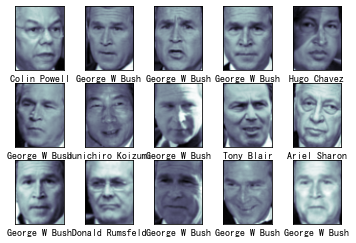

In [17]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

In [18]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=40)

In [19]:
import cv2
# train the model
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10],
              'svc__gamma': [0.0001, 0.0005, 0.001]}
#model = cv2.face.LBPHFaceRecognizer_create()
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)

Wall time: 9.11 s


GridSearchCV(estimator=Pipeline(steps=[('pca',
                                        PCA(n_components=150, random_state=42,
                                            whiten=True)),
                                       ('svc', SVC(class_weight='balanced'))]),
             param_grid={'svc__C': [1, 5, 10],
                         'svc__gamma': [0.0001, 0.0005, 0.001]})

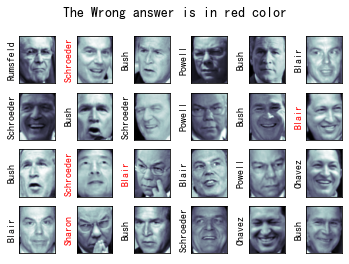

In [20]:
model = grid.best_estimator_
yfit = model.predict(Xtest)
yfit.shape
import matplotlib as mpl
mpl.rcParams["font.sans-serif"] = ["SimHei"]
mpl.rcParams["axes.unicode_minus"] = False
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    #
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('The Wrong answer is in red color', size=14);

In [21]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.50      0.50      0.50        16
     Colin Powell       0.69      0.81      0.75        54
  Donald Rumsfeld       0.83      0.85      0.84        34
    George W Bush       0.94      0.88      0.91       136
Gerhard Schroeder       0.72      0.85      0.78        27
      Hugo Chavez       0.81      0.72      0.76        18
Junichiro Koizumi       0.87      0.87      0.87        15
       Tony Blair       0.85      0.76      0.80        37

         accuracy                           0.82       337
        macro avg       0.78      0.78      0.78       337
     weighted avg       0.83      0.82      0.82       337



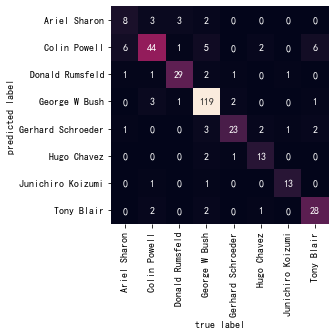

In [22]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# 混淆矩阵
mat = confusion_matrix(ytest, yfit)
# 注意这里的混淆矩阵的画图
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');